In [1]:
!pip install wordcloud-fa
!pip install gensim

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 368kB 11.8MB/s 
     |████████████████████████████████| 317kB 17.0MB/s 
     |████████████████████████████████| 235kB 18.7MB/s 
     |████████████████████████████████| 1.4MB 23.8MB/s 
  Created wheel for wordcloud-fa: filename=wordcloud_fa-0.1.8-cp36-none-any.whl size=71016 sha256=5aa32ae9487be41a10d13e9dceda76d68f4bc139aa71cc193cd14eb3847435bb
  Stored in directory: /root/.cache/pip/wheels/37/dd/e9/d6d14e3faa089ffa1bc80ae6f713ca91d2ffd0bb786edcdef5
  Created wheel for arabic-reshaper: filename=arabic_reshaper-2.1.1-cp36-none-any.whl size=16504 sha256=e996c1b4c66756e190a1572962ebb6a1bef1b0493194c0b12668365681b5a805
  Stored in directory: /root/.cache/pip/wheels/62/52/d8/bd0dcbf00f9e77e3bd0184285ed77dfa9c475dac494a5353d1
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp36-cp36m-linux_x86_64.whl size=154579 sha256=f378376c62e54eb5f6842d4f14123bf8f237b8a93ad855d0b6bdeac69b961cbc
  Stored

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
# from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten

import re
print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Tensorflow Version 2.4.1


In [3]:
# df = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/7-offDSA2020-dev-train-8000.xlsx')
df = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/7-offDSA2020-dev-train-8000-MixWithNuhaDS1.xlsx')
df.head()

,tweets,off,hs,new-label
0,فى حاجات مينفعش نلفت نظركوا ليها زى الاصول كده...,NOT_OFF,NOT_HS,not-hate
1,RT @USER: وعيون تنادينا تحايل فينا و نقول يا ع...,NOT_OFF,NOT_HS,not-hate
2,يا بلادي يا أم البلاد يا بلادي بحبك يا مصر بحب...,NOT_OFF,NOT_HS,not-hate
3,RT @USER: يا رب يا قوي يا معين مدّني بالقوة و ...,NOT_OFF,NOT_HS,not-hate
4,RT @USER: رحمك الله يا صدام يا بطل ومقدام. URL,NOT_OFF,NOT_HS,not-hate


In [4]:
#Test data
test = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/test.xlsx')
test.head()

,tweets
0,@USER اما انت تقعد طول عمرك لا مبدا ولا راي ث...
1,@USER @USER بتخاف نسوانك يزعلوا ولا ايه 😂 اه ...
2,RT @USER: يا عـسانـى نـبـقى يا عـمري حـبايـب ...
3,RT @USER: باقي البيان وينو ما شفنه يا برهان <...
4,@USER @USER اللهم انت الشافي المعافي اشفيه وج...


In [5]:
#Actual result data
actual = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/actual.xlsx')
actual.head()


,off
0,OFF
1,OFF
2,NOT_OFF
3,OFF
4,NOT_OFF


In [7]:
df.columns = ['tweets', 'off','hs','new_label']
test.columns = ['tweets']
actual.columns=['off']
df.head()
# actual.head()

,tweets,off,hs,new_label
0,فى حاجات مينفعش نلفت نظركوا ليها زى الاصول كده...,NOT_OFF,NOT_HS,not-hate
1,RT @USER: وعيون تنادينا تحايل فينا و نقول يا ع...,NOT_OFF,NOT_HS,not-hate
2,يا بلادي يا أم البلاد يا بلادي بحبك يا مصر بحب...,NOT_OFF,NOT_HS,not-hate
3,RT @USER: يا رب يا قوي يا معين مدّني بالقوة و ...,NOT_OFF,NOT_HS,not-hate
4,RT @USER: رحمك الله يا صدام يا بطل ومقدام. URL,NOT_OFF,NOT_HS,not-hate


In [9]:
df = df.drop(['hs','new_label'], axis=1)
# test = test.drop(['off'], axis=1)

KeyError: ignored

Text(0.5, 1.0, 'Hate speech Data Distribution')

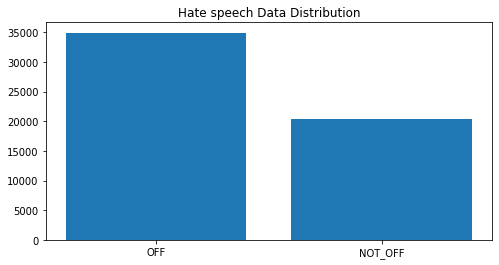

In [10]:
val_count = df.off.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Hate speech Data Distribution")

In [11]:
import random
random_idx_list = [random.randint(1,len(df.tweets)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,tweets,off
49027,ولماذا هؤلاء لم يذهبوا الى اسرائيل لتحرير القد...,OFF
7053,ياوطن المتعبين يا آخر الطلقات يا مِلحَ وجهك فو...,NOT_OFF
8452,ليش مسحوب عليي سحبه يهود قريش؟! ترى عندي سيات ...,OFF
5388,@USER يا حبيبتي يا ميعاد انتي من الاوفاء اللي ...,NOT_OFF
51163,مدام جبران باسيل سرق و عمر بالمصاري قصر بمعراب...,OFF
122,😂😂😂😂😂 يا حسرة يا حسرة يلااا يابنى انتو وهو يا ...,NOT_OFF
22820,بماذا تستخدموا اختراعات اسيادكم,OFF
29914,الحل هو محاكمتكم بمحاكم الجنايات الدولية يا مج...,OFF
53760,مظبوط مضيع,NOT_OFF
24708,و مصر تدعم الشعب السورى فى حريته المطلقة فى اخ...,NOT_OFF


#Text Preprocessing¶


In [12]:
import gensim

In [13]:
# load the model
modelwv = gensim.models.Word2Vec.load('/content/drive/MyDrive/MasterThesis/Code/Offensive2020-SharedTask-Dataset/WE/Twt-CBOW/Twt-CBOW')

In [14]:
text_cleaning_re = "[a-zA-Z]|\d+|[٠١٢٣٤٥٦٧٨٩]|[.#،<>/@,\\-_”“٪ًَ]"
# stop_words = stopwords.words('arabic')
stop_words=[
          'من','في'
]
def preprocess(text):
  
  #remove tashkeel
  p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
  text = re.sub(p_tashkeel,"", str(text))
  # text = text.replace('وو', 'و')
  # text = text.replace('يي', 'ي')
  # text = text.replace('اا', 'ا')
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  #remove longation
  text = re.sub(r'(.)\1+', r'\1\1', str(text)) 
  text = re.sub("[إأآا]", "ا", str(text))
  text = re.sub("ى", "ي", str(text))
  text = re.sub(r'\\', '', str(text))
  # text = re.sub("ئ", "ء", text)
  text = re.sub("ة", "ه", str(text))
  # for i in range(0, len(search)):
  #       text = text.replace(search[i], replace[i])
  
   #trim    
  # text = text.strip()

  tokens = []
  for token in text.split():
    if token not in stop_words:
      tokens.append(token)
  return " ".join(tokens)

In [15]:
stop_words

['من', 'في']

In [16]:
preprocess('هههًه في من على ههه\/ 156562سٌلمُ@#')

'هه علي هه سلم'

In [17]:
word = preprocess(u'حقير')

# find and print the most similar terms to a word
most_similar = modelwv.wv.most_similar( word )
for term, score in most_similar:
	print(term, score)

سافل 0.6879982352256775
خسيس 0.6644033193588257
قذر 0.6214959621429443
منحط 0.6129060983657837
وقح 0.6018147468566895
غبي 0.5982157588005066
وحقير 0.5942843556404114
وسافل 0.5851724743843079
ومنحط 0.5787683725357056
جبان 0.5700664520263672


In [18]:
word_vector = modelwv.wv[ word ]
# word_vector

In [19]:
df.tweets = df.tweets.apply(lambda x: preprocess(x))
df.tweets[:10]
# df.head(10)

0    حاجات مينفعش نلفت نظركوا ليها زي الاصول كده يا...
1    : وعيون تنادينا تحايل فينا و نقول يا عيونه يا ...
2    يا بلادي يا ام البلاد يا بلادي بحبك يا مصر بحب...
3    : يا رب يا قوي يا معين مدني بالقوه و العون و ا...
4                    : رحمك الله يا صدام يا بطل ومقدام
5    يا جابر يا بنجرجي يا مرتزق يا حثاله الحمدين يا...
6    : يا انـت يا بعضــي وكلــي وذاتــي يا لـون الف...
7                    كحل عينك يا منحط يا وضيع يا متخلف
8    لعنه الله عليك يا النذل يا الواطي ولعنه الله ع...
9    يا قلب يا احد الاصغرين كيف اتسعت لهذا الوجود ؟...
Name: tweets, dtype: object

In [20]:
# def remove_Eng_Char(input_text):
#         return re.sub('[a-zA-Z]', '', str(input_text))
#         # return re.sub(r'[a-zA-Z]|\d+|[٠١٢٣٤٥٦٧٨٩]', '', str(input_text))
        
# def remove_Numbers(input_text):
#     return re.sub(r'\d+|[٠١٢٣٤٥٦٧٨٩]', ' ', str(input_text)) 

# def remove_Punct(input_text):
#     return re.sub(r'[.،<>@,\\-_”“٪ًَ]', ' ', str(input_text)) 

# def remove_repeating_char(text):
#     return re.sub(r'(.)\1+', r'\1\1', str(text))     # keep 2 repeat
    
# def normalize_arabic(text):
#     # text = remove_diacritics(text)
#     text = re.sub("[إأآا]", "ا", text)
#     text = re.sub("ى", "ي", text)
#     text = re.sub("ؤ", "ء", text)
#     text = re.sub("ئ", "ء", text)
#     text = re.sub("ة", "ه", text)
#     text = re.sub("گ", "ك", text)
#     return text

# # x=remove_repeating_char('مشكووووور ،!؟')     
# print(df.head())

# df.tweets = df.tweets.apply(remove_repeating_char).apply(remove_Eng_Char).apply(normalize_arabic).apply(remove_Numbers).apply(remove_Punct)
# print(df.head())

In [21]:
# #Not Offensive Words
# from wordcloud_fa import WordCloudFa


# plt.figure(figsize = (20,20)) 
# wc=WordCloudFa(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.off == 'NOT_OFF'].tweets))

# image = wc.to_image()
# image.save('wordcloud.png')
# plt.imshow(wc , interpolation = 'bilinear')

In [22]:
# plt.figure(figsize = (20,20)) 
# wc=WordCloudFa(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.off == 'OFF'].tweets))
# image = wc.to_image()
# image.save('wordcloudoff.png')
# plt.imshow(wc , interpolation = 'bilinear')

# Train and Test Split

In [23]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 30


In [24]:
train_data, val_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(val_data))

Train Data size: 44317
Test Data size 11080


In [25]:
train_data.head(10)


,tweets,off
34259,و ما هو رد امير المؤمنيين ملك السعوديه سلمان ا...,OFF
42088,اﻻيراني بعقيده السعودي مجرم يضخ نفطا بالسوق ﻻ ...,OFF
21212,انا احب المصريين وكذلك اكثر اهل الخليج يحبون ا...,NOT_OFF
12030,صرحه نذير وبراءه للذمه: البهره اليمن! : الشيعه...,NOT_OFF
17804,الراجل بيقول وثائق ايه لزمه الشتيمه,NOT_OFF
12673,فرح كثير الناس بزلزال ايران و عدوه انتقاما ربا...,NOT_OFF
36854,يجب انتقضون علي ذلكالكيان الصهيوني وكل ايرانيم...,OFF
31077,العربيه لغه القران و هي بقدسيته و لا يشرفنا كم...,OFF
44396,هذه حقيقه تصرفات العدو البككي البيشمركي فقد قت...,OFF
25811,نقول لهذا المعتوه اسيادك طهران تخلو عنك ولا ام...,OFF


In [26]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.tweets)
tokenizer.fit_on_texts(val_data.tweets)

tokenizer.fit_on_texts(test.tweets)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)


Vocabulary Size : 139094


In [27]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweets),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(val_data.tweets),
                       maxlen = MAX_SEQUENCE_LENGTH)

test=pad_sequences(tokenizer.texts_to_sequences(test.tweets),maxlen=MAX_SEQUENCE_LENGTH)
print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)
print("Testing X Shape:",test.shape)


Training X Shape: (44317, 30)
Testing X Shape: (11080, 30)
Testing X Shape: (2000, 30)


In [28]:
labels = train_data.off.unique().tolist()
labels

['OFF', 'NOT_OFF']

In [29]:
encoder = LabelEncoder()
encoder.fit(train_data.off.to_list())
encoder.fit(val_data.off.to_list())
# encoder.fit(actual.off.to_list())

y_train = encoder.transform(train_data.off.to_list())
y_test = encoder.transform(val_data.off.to_list())
# actual = encoder.transform(actual.off.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
# actual = actual.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
# print("actual shape:", actual.shape)

y_train shape: (44317, 1)
y_test shape: (11080, 1)


# Word embedding

In [30]:
# !wget http://mazajak.inf.ed.ac.uk:8000/get_sg_250

# !wget https://www.dropbox.com/s/ce9phmmawoe1ure/Twt-CBOW.zip

In [31]:
# !unzip Twt-CBOW.zip
# !gunzip -k get_sg_250.bin

In [32]:
# !ls

In [33]:
# GLOVE_EMB = '/content/drive/MyDrive/MasterThesis/Code/Offensive2020-SharedTask-Dataset/WE/Twt-CBOW/Twt-CBOW'
EMBEDDING_DIM = 300
LR = 1e-2
BATCH_SIZE = 1024
EPOCHS = 100
# MODEL_PATH = '/content/best_model.hdf5'

In [34]:
# load the model
# modelwv = gensim.models.Word2Vec.load('/content/drive/MyDrive/MasterThesis/Code/Offensive2020-SharedTask-Dataset/WE/Twt-CBOW/Twt-CBOW')

In [35]:
# embeddings_index = {}

# f = open(GLOVE_EMB)
# for line in f:
#   values = line.split()
#   word = value = values[0]
#   coefs = np.asarray(values[1:], dtype='float32')
#   embeddings_index[word] = coefs
# f.close()

# print('Found %s word vectors.' %len(embeddings_index))

# -------------------------------------------------------- #

# embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
# for word, i in word_index.items():
#   embedding_vector = embeddings_index.get(word)
#   if embedding_vector is not None:
#     embedding_matrix[i] = embedding_vector



In [36]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in modelwv.wv.vocab:
      embedding_vector = modelwv[word]
    else:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [37]:
print(embedding_matrix.shape)
# EMBEDDING_DIM=300


(139094, 300)


In [38]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

#Model Training - LSTM


In [39]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from keras.layers import Dropout,Embedding,GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model


In [40]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Dropout(0.5)(x)

# Conv1D + global max pooling
x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
# x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [41]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
# ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
#                                      min_lr = 0.01,
#                                      monitor = 'val_loss',
#                                      verbose = 1)

In [42]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss',patience=5)])

Epoch 1/100
44/44 [==============================] - 9s 45ms/step - loss: 0.7031 - accuracy: 0.6108 - val_loss: 0.6536 - val_accuracy: 0.6301
Epoch 2/100
44/44 [==============================] - 2s 38ms/step - loss: 0.6519 - accuracy: 0.6292 - val_loss: 0.6512 - val_accuracy: 0.6301
Epoch 3/100
44/44 [==============================] - 2s 38ms/step - loss: 0.6482 - accuracy: 0.6283 - val_loss: 0.6529 - val_accuracy: 0.6301
Epoch 4/100
44/44 [==============================] - 2s 37ms/step - loss: 0.6422 - accuracy: 0.6290 - val_loss: 0.6543 - val_accuracy: 0.6302
Epoch 5/100
44/44 [==============================] - 2s 38ms/step - loss: 0.6343 - accuracy: 0.6318 - val_loss: 0.6524 - val_accuracy: 0.6301
Epoch 6/100
44/44 [==============================] - 2s 37ms/step - loss: 0.6364 - accuracy: 0.6311 - val_loss: 0.6570 - val_accuracy: 0.6298
Epoch 7/100
44/44 [==============================] - 2s 37ms/step - loss: 0.6311 - accuracy: 0.6363 - val_loss: 0.6554 - val_accuracy: 0.6313


In [43]:
scores = model.evaluate(x_train,y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 63.46%


In [44]:
y_pred = model.predict(test,batch_size=10,verbose=1)
# print(x_test[:2])
# print(y_pred[:2])
y_classes= np.argmax(y_pred,axis=1)
# print(y_classes)
# list(encoder.inverse_transform(y_classes))
# encoder.inverse_transform(y_classes)
y_classes

200/200 [==============================] - 1s 2ms/step


array([0, 0, 0, ..., 0, 0, 0])

In [45]:
actual.columns=['off']
actual.off = pd.Categorical(actual.off)
actual['OffCode'] = actual.off.cat.codes
y_actual=actual['OffCode']
actual.head()
y_actual

0       1
1       1
2       0
3       1
4       0
       ..
1995    1
1996    0
1997    0
1998    1
1999    1
Name: OffCode, Length: 2000, dtype: int8

In [46]:
from sklearn.metrics import accuracy_score
print(y_classes)
print(accuracy_score(y_actual, y_classes))


[0 0 0 ... 0 0 0]
0.799


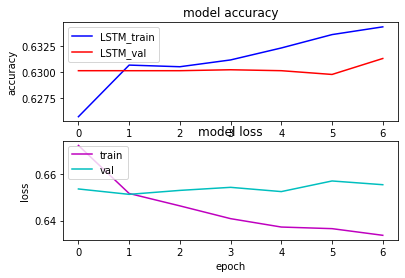

In [47]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [48]:
# MAX_SEQUENCE_LENGTH=80
# totest=["انت حقير جدا "]
# totest=[i.split(" ") for i in totest]
# print(totest)
# Xnew=np.array(tokenizer.texts_to_sequences(totest))
# Xnew = pad_sequences(Xnew, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
# ynew = model.predict(Xnew)

# result=np.argmax(ynew,axis=1)
# for k,v in label_index.items():
#   if v==result:
#     print(k)

In [49]:
def decode_sentiment(score):
    return "NOT_OFF" if score>0.5 else "OFF"


scores = model.predict(test, verbose=1, batch_size=100)
y_pred_1d = [decode_sentiment(score) for score in scores]

20/20 [==============================] - 0s 3ms/step


#Confusion Matrix¶


In [50]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)


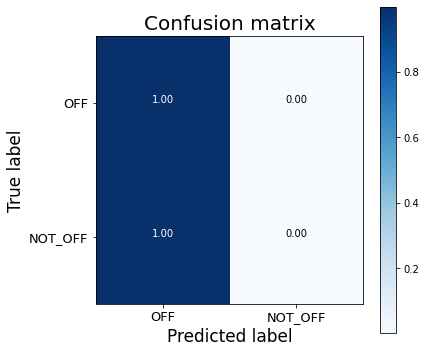

In [51]:
cnf_matrix = confusion_matrix(actual.off.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=actual.off.unique(), title="Confusion matrix")
plt.show()

In [52]:
#Classification Scores

print(classification_report(list(actual.off), y_pred_1d))


              precision    recall  f1-score   support

     NOT_OFF       0.80      1.00      0.89      1598
         OFF       0.12      0.00      0.00       402

    accuracy                           0.80      2000
   macro avg       0.46      0.50      0.45      2000
weighted avg       0.66      0.80      0.71      2000



In [53]:
# filepath="weights_base.best.hdf5"
# y_pred = model.predict(x_test,batch_size=1024,verbose=1)

In [54]:
# submission = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv')
# submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred

In [55]:
# from tensorflow.keras import layers
# max_features = 20000
# embedding_dim = 128
# sequence_length = 500
# # A integer input for vocab indices.
# inputs = tf.keras.Input(shape=(None,), dtype="int64")

# # Next, we add a layer to map those vocab indices into a space of dimensionality
# # 'embedding_dim'.
# x = layers.Embedding(max_features, embedding_dim)(inputs)
# x = layers.Dropout(0.5)(x)

# # Conv1D + global max pooling
# x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
# x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
# x = layers.GlobalMaxPooling1D()(x)

# # We add a vanilla hidden layer:
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dropout(0.5)(x)

# # We project onto a single unit output layer, and squash it with a sigmoid:
# predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

# model = tf.keras.Model(inputs, predictions)

# # Compile the model with binary crossentropy loss and an adam optimizer.
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [56]:
# epochs = 20

# # Fit the model using the train and test datasets.
# model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=epochs)